In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [16]:
# All in RGB
all_valid_colors = [
    [0, 0, 0],
	[255, 255, 255],
	[231, 120, 23],
	[0, 147, 221],
	[245, 240, 20],
	[75, 176, 51],
	[218, 37, 29],
]

In [17]:
# Convert all valid colors into their HSV and print them


all_valid_HSV = []

# skip black and white
for color in all_valid_colors[2:]:
	color = np.array(color, dtype=np.uint8)
	hsv_color = cv2.cvtColor(color.reshape(1, 1, 3), cv2.COLOR_RGB2HSV)[0][0]
	print(f'RGB: {color}, HSV: {hsv_color}')
	all_valid_HSV.append(hsv_color)


print(all_valid_HSV)

RGB: [231 120  23], HSV: [ 14 230 231]
RGB: [  0 147 221], HSV: [100 255 221]
RGB: [245 240  20], HSV: [ 29 234 245]
RGB: [ 75 176  51], HSV: [ 54 181 176]
RGB: [218  37  29], HSV: [  1 221 218]
[array([ 14, 230, 231], dtype=uint8), array([100, 255, 221], dtype=uint8), array([ 29, 234, 245], dtype=uint8), array([ 54, 181, 176], dtype=uint8), array([  1, 221, 218], dtype=uint8)]


In [18]:
full_img_path = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00000.jpg"
full_img = np.array(cv2.imread(full_img_path, cv2.IMREAD_COLOR))
full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2HSV).astype(np.float32) / 255.0

reference_HSV = np.array(all_valid_HSV).astype(np.float32) / 255.0

def get_hue_masks(full_img, reference_HSV, black_mask=None, white_mask=None, weights=[1.0,0.0,0.0], threshold=0.75, sigma=0.05):
	'''
	Gets an image loaded in HSV format and an array of reference HSV colors
	Both are normalized to 1.0 max np.float32 values
	Returns an array of masks, one for each reference HSV color, with white pixels in regions matching
	to a certain degree the corresponding reference HSV color.

	Args:
		full_img: HSV image normalized to [0,1]
		reference_HSV: Array of reference HSV colors for chromatic colors
		black_mask: Binary mask (0-255) where black pixels are 255, used to exclude from chromatic processing
		white_mask: Binary mask (0-255) where white pixels are 255, used to exclude from chromatic processing
		weights: [w_h, w_s, w_v] weights for hue, saturation, value distances
		threshold: Threshold for binary mask creation
		sigma: Gaussian kernel sigma for soft assignment
	
	Returns:
		List of binary masks (0-255) for each reference HSV color
	'''
	h, w, _ = full_img.shape
	pixels_hsv = full_img.reshape(-1, 3)  # (num_pixels, 3)

	# Compute circular hue distance
	h_diff = np.abs(pixels_hsv[:, None, 0] - reference_HSV[None, :, 0])
	h_dist = np.minimum(h_diff, 1.0 - h_diff)

	# Create exclusion mask from black and white pixels
	exclusion_mask = np.zeros(h * w, dtype=bool)
	
	if black_mask is not None:
		black_pixels = (black_mask.reshape(-1) > 0)
		exclusion_mask |= black_pixels
	
	if white_mask is not None:
		white_pixels = (white_mask.reshape(-1) > 0)
		exclusion_mask |= white_pixels

	# Mask out pixels that are already classified as black or white
	h_dist[exclusion_mask, :] = np.inf

	s_dist = np.abs(pixels_hsv[:, None, 1] - reference_HSV[None, :, 1]) if weights[1] > 0 else np.zeros_like(h_dist)
	v_dist = np.abs(pixels_hsv[:, None, 2] - reference_HSV[None, :, 2]) if weights[2] > 0 else np.zeros_like(h_dist)

	w_h, w_s, w_v = weights
	dists = np.sqrt(
		w_h * h_dist**2 
		+ w_s * s_dist**2
		+ w_v * v_dist**2
				 )

	# Soft assignment using Gaussian kernel
	weights_soft = np.exp(- (dists**2) / (2 * sigma**2))  # shape (num_pixels, num_colors)

	# For masked out pixels (inf), set weights to 0
	weights_soft[np.isinf(dists)] = 0

	# Reshape back to (h, w, num_colors)
	weights_img = weights_soft.reshape(h, w, -1)

	results_hsv = []
	for i in range(len(reference_HSV)):
		channel = weights_img[:, :, i]
		binary_mask = (channel > threshold).astype(np.uint8)
		results_hsv.append(binary_mask * 255)

	return results_hsv

def get_white_mask(full_img, sat_threshold=0.2, val_threshold=0.6):
	'''
	Creates a mask for white pixels based on HSV characteristics:
	- Low saturation (S < sat_threshold) 
	- High value (V > val_threshold)
	
	Args:
		full_img: HSV image normalized to [0,1]
		sat_threshold: Maximum saturation for white pixels
		val_threshold: Minimum value for white pixels
	
	Returns:
		Binary mask (0-255) where white pixels are 255
	'''
	# White: low saturation AND high value
	white_mask = (full_img[:, :, 1] < sat_threshold) & (full_img[:, :, 2] > val_threshold)
	
	return (white_mask * 255).astype(np.uint8)

def get_black_mask(full_img, val_threshold=0.2):
	'''
	Creates a mask for black pixels based on HSV characteristics:
	- Very low value (V < val_threshold) regardless of hue and saturation
	
	Args:
		full_img: HSV image normalized to [0,1]
		val_threshold: Maximum value for black pixels
	
	Returns:
		Binary mask (0-255) where black pixels are 255
	'''
	# Black: very low value regardless of hue and saturation
	black_mask = full_img[:, :, 2] < val_threshold
	
	return (black_mask * 255).astype(np.uint8)

In [ ]:
# STEP 1: Get masks for white and black first using proper HSV definitions
print("Step 1: Computing white and black masks...")
white_mask = get_white_mask(full_img)
black_mask = get_black_mask(full_img)

print(f"White pixels: {np.count_nonzero(white_mask)} ({np.count_nonzero(white_mask)/white_mask.size*100:.2f}%)")
print(f"Black pixels: {np.count_nonzero(black_mask)} ({np.count_nonzero(black_mask)/black_mask.size*100:.2f}%)")

# STEP 2: Get masks for chromatic colors, excluding pixels already classified as black or white
print("\nStep 2: Computing chromatic color masks (excluding black/white pixels)...")
results_hsv = get_hue_masks(full_img, reference_HSV, black_mask=black_mask, white_mask=white_mask)

# STEP 3: Combine all masks
all_masks = results_hsv + [white_mask, black_mask]
all_color_names = ['Orange', 'Blue', 'Yellow', 'Green', 'Red', 'White', 'Black']

print(f"\nCreated {len(all_masks)} masks total:")
for i, name in enumerate(all_color_names):
    print(f"  {i}: {name}")

# Show detailed statistics
print("\nDetailed mask statistics:")
total_pixels = all_masks[0].size
classified_pixels = 0

for i, (mask, name) in enumerate(zip(all_masks, all_color_names)):
    non_zero_pixels = np.count_nonzero(mask)
    percentage = (non_zero_pixels / total_pixels) * 100
    print(f"  {name}: {non_zero_pixels}/{total_pixels} pixels ({percentage:.2f}%)")
    classified_pixels += non_zero_pixels



Step 1: Computing white and black masks...
White pixels: 5032223 (41.27%)
Black pixels: 1715038 (14.07%)

Step 2: Computing chromatic color masks (excluding black/white pixels)...

Created 7 masks total:
  0: Orange
  1: Blue
  2: Yellow
  3: Green
  4: Red
  5: White
  6: Black

Detailed mask statistics:
  Orange: 1100709/12192768 pixels (9.03%)
  Blue: 839421/12192768 pixels (6.88%)
  Yellow: 631243/12192768 pixels (5.18%)
  Green: 25966/12192768 pixels (0.21%)
  Red: 414482/12192768 pixels (3.40%)
  White: 5032223/12192768 pixels (41.27%)
  Black: 1715038/12192768 pixels (14.07%)


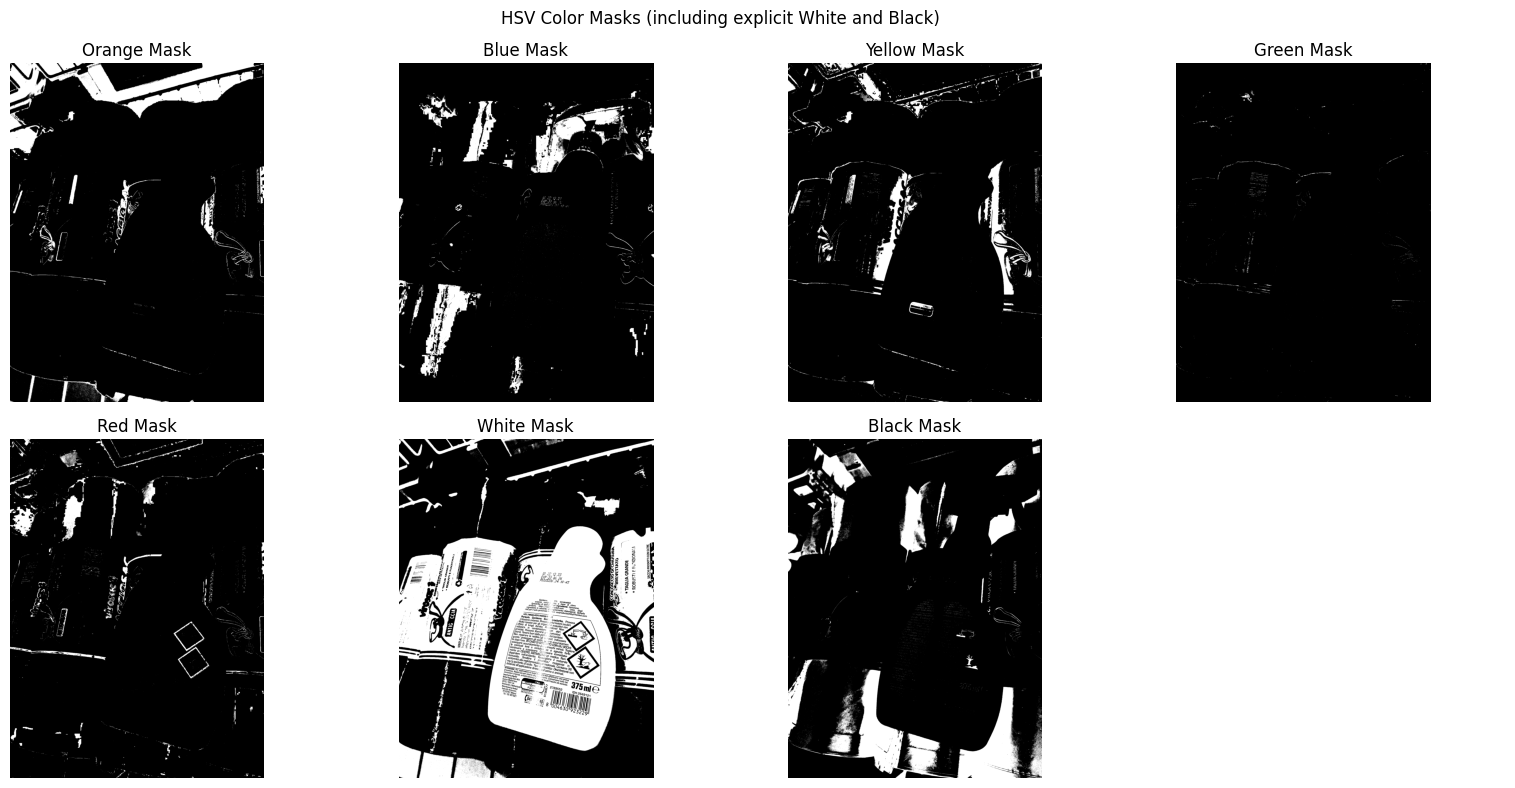

In [20]:
# Visualize all masks in a grid
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("HSV Color Masks (including explicit White and Black)")

for i, (mask, name) in enumerate(zip(all_masks, all_color_names)):
    row = i // 4
    col = i % 4
    if row < 2 and col < 4:
        axs[row, col].imshow(mask, cmap='gray')
        axs[row, col].set_title(f"{name} Mask")
        axs[row, col].axis('off')

# Hide unused subplot
if len(all_masks) < 8:
    axs[1, 3].axis('off')

plt.tight_layout()
plt.show()

Parameter tuning demonstration:

White (sat<0.05, val>0.9): 1178255 pixels (9.66%)
White (sat<0.1, val>0.8): 2573222 pixels (21.10%)
White (sat<0.2, val>0.6): 5032223 pixels (41.27%)


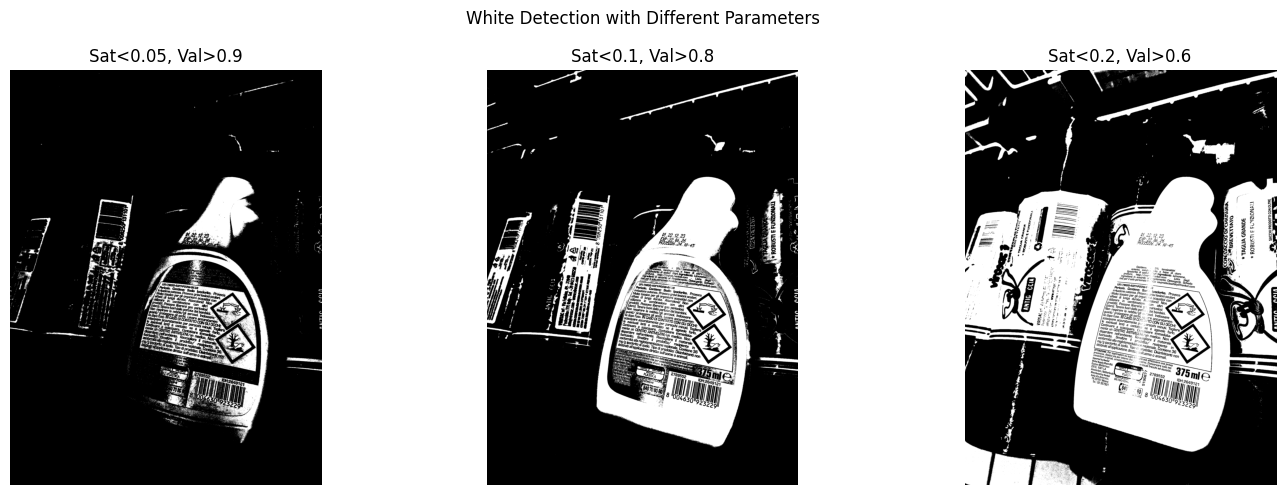

Black (val<0.1): 610550 pixels (5.01%)
Black (val<0.2): 1715038 pixels (14.07%)
Black (val<0.3): 3565808 pixels (29.25%)


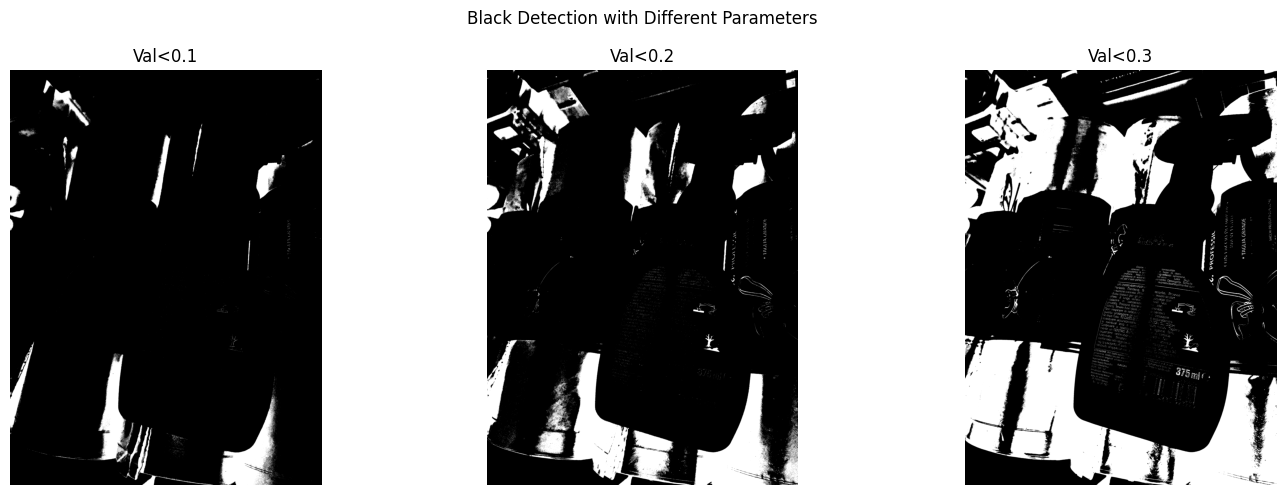

In [21]:
# Demonstrate parameter tuning for white and black detection
print("Parameter tuning demonstration:\n")

# Test different white detection parameters
white_params = [
    (0.05, 0.9),  # Very strict white
    (0.1, 0.8),   # Default white
    (0.2, 0.6),   # More lenient white
]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("White Detection with Different Parameters")

for i, (sat_thresh, val_thresh) in enumerate(white_params):
    white_test = get_white_mask(full_img, sat_threshold=sat_thresh, val_threshold=val_thresh)
    axs[i].imshow(white_test, cmap='gray')
    axs[i].set_title(f"Sat<{sat_thresh}, Val>{val_thresh}")
    axs[i].axis('off')
    
    pixels = np.count_nonzero(white_test)
    percentage = (pixels / white_test.size) * 100
    print(f"White (sat<{sat_thresh}, val>{val_thresh}): {pixels} pixels ({percentage:.2f}%)")

plt.tight_layout()
plt.show()

# Test different black detection parameters  
black_params = [0.1, 0.2, 0.3]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Black Detection with Different Parameters")

for i, val_thresh in enumerate(black_params):
    black_test = get_black_mask(full_img, val_threshold=val_thresh)
    axs[i].imshow(black_test, cmap='gray')
    axs[i].set_title(f"Val<{val_thresh}")
    axs[i].axis('off')
    
    pixels = np.count_nonzero(black_test)
    percentage = (pixels / black_test.size) * 100
    print(f"Black (val<{val_thresh}): {pixels} pixels ({percentage:.2f}%)")

plt.tight_layout()
plt.show()


Testing different sigma values for color selection:
Selected color: Red (index 4)
Testing sigma values: [0.025, 0.05, 0.075, 0.1]

Sigma 0.0250: 310929 pixels (2.55%)
Sigma 0.0500: 414482 pixels (3.40%)
Sigma 0.0750: 836932 pixels (6.86%)
Sigma 0.1000: 1242816 pixels (10.19%)


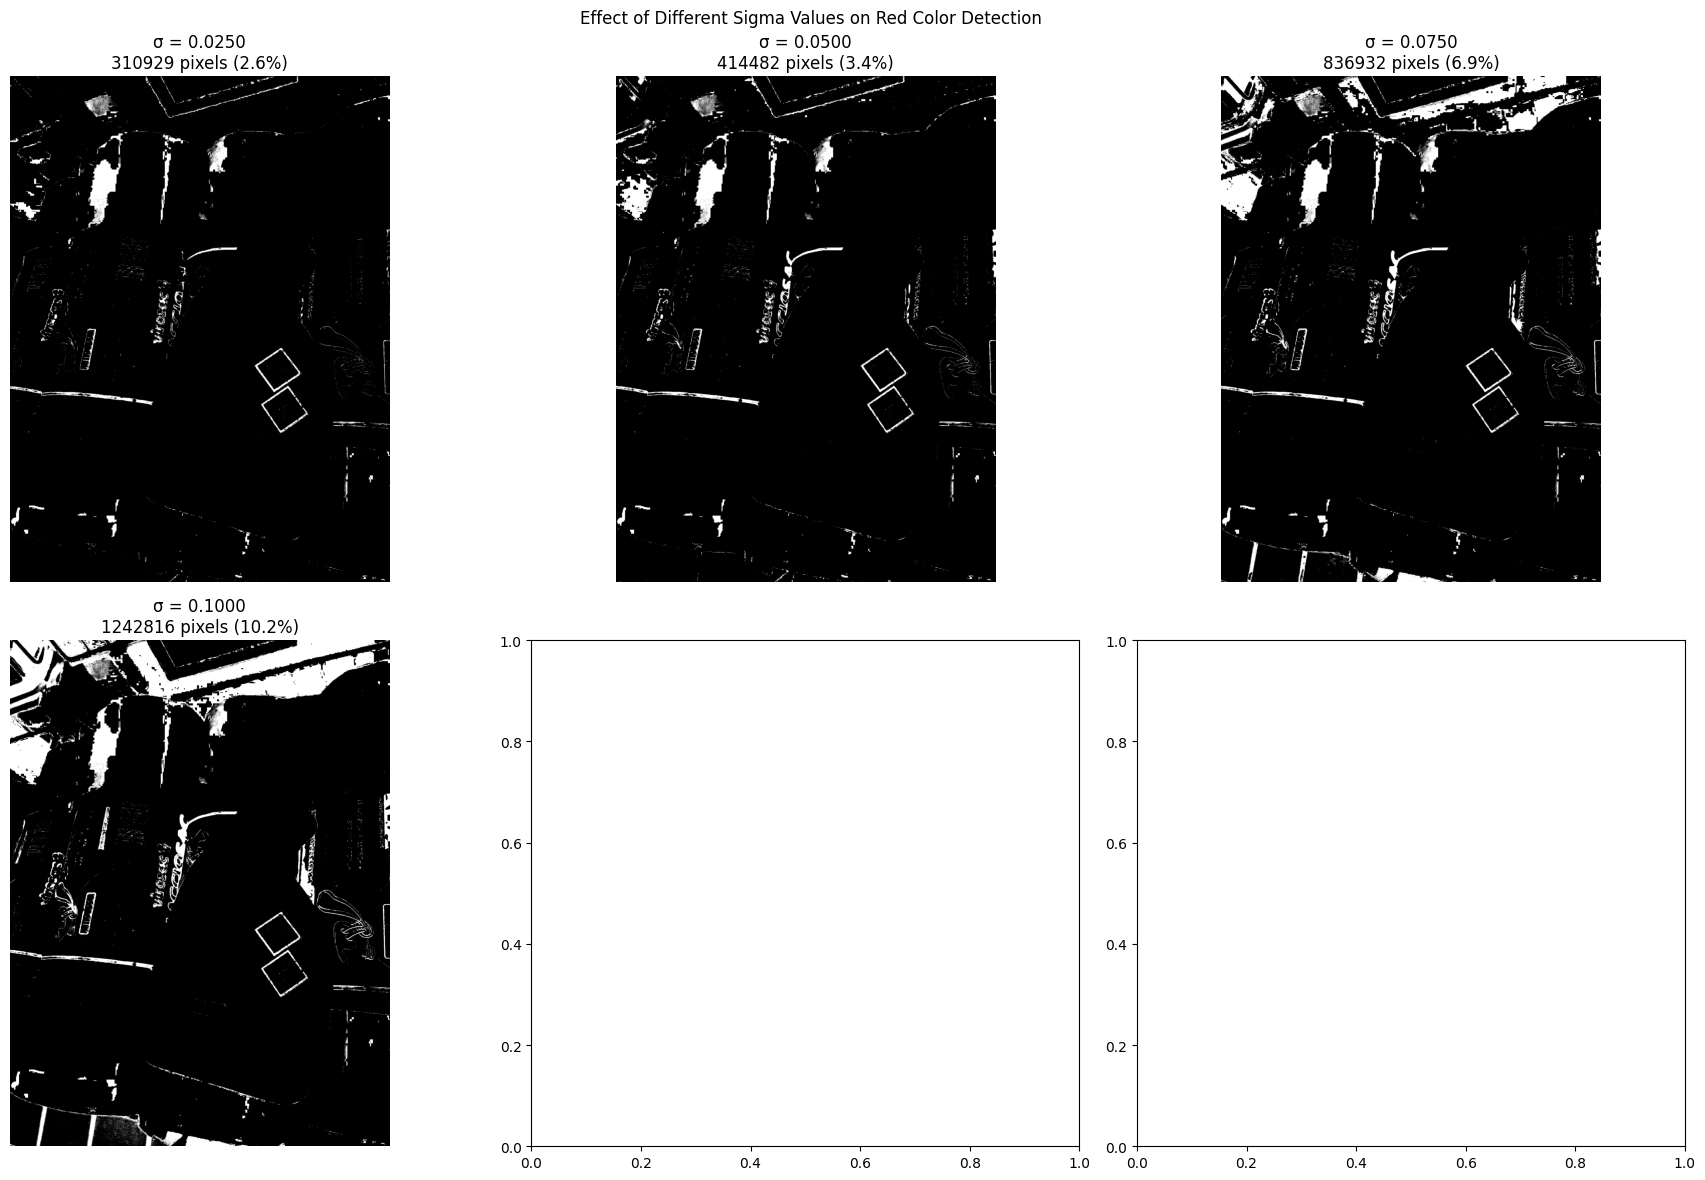


Statistical Summary:
----------------------------------------
Sigma    Pixels   Percentage   Change    
----------------------------------------
0.0250   310929   2.6          baseline  
0.0500   414482   3.4          +0        
0.0750   836932   6.9          +422450   
0.1000   1242816  10.2         +828334   


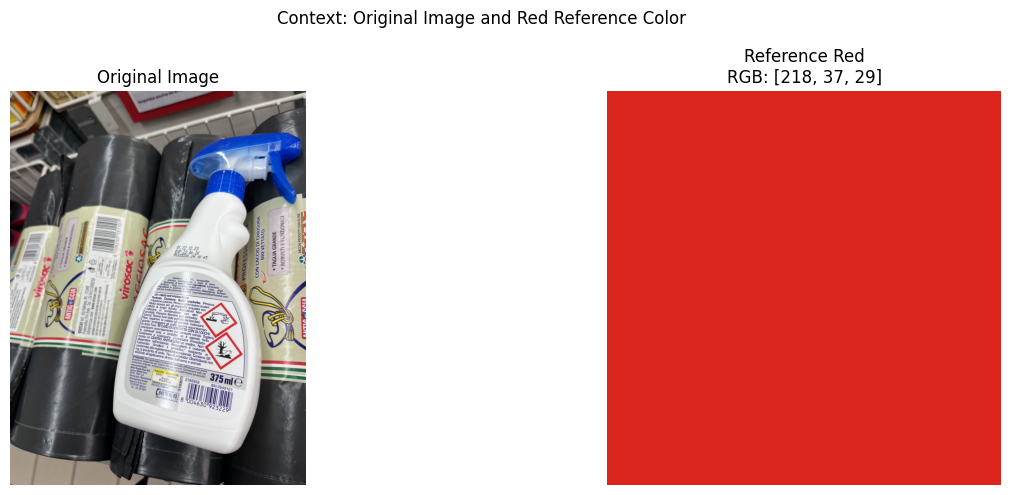

In [22]:
# Test different sigma values for a selected color
print("Testing different sigma values for color selection:")
print("="*50)

# CONFIGURATION: Select which color to focus on
color_index = 4 
color_name = ['Orange', 'Blue', 'Yellow', 'Green', 'Red'][color_index]

# CONFIGURATION: Sigma values to test
sigma_values = [0.025, 0.05, 0.075, 0.1]

print(f"Selected color: {color_name} (index {color_index})")
print(f"Testing sigma values: {sigma_values}\n")

# Get baseline white and black masks (these don't change with sigma)
white_mask_baseline = get_white_mask(full_img)
black_mask_baseline = get_black_mask(full_img)

# Test different sigma values
results = []
for sigma in sigma_values:
    # Get chromatic color masks with this sigma value
    chromatic_masks = get_hue_masks(full_img, reference_HSV, black_mask_baseline, white_mask_baseline, sigma=sigma)
    
    # Extract the mask for our selected color
    selected_mask = chromatic_masks[color_index]
    
    # Calculate statistics
    pixels = np.count_nonzero(selected_mask)
    percentage = (pixels / selected_mask.size) * 100
    
    results.append({
        'sigma': sigma,
        'mask': selected_mask,
        'pixels': pixels,
        'percentage': percentage
    })
    
    print(f"Sigma {sigma:0.4f}: {pixels} pixels ({percentage:.2f}%)")

# Visualize results
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f"Effect of Different Sigma Values on {color_name} Color Detection")

for i, result in enumerate(results):
    row = i // 3
    col = i % 3
    
    if row < 2 and col < 3:
        axs[row, col].imshow(result['mask'], cmap='gray')
        axs[row, col].set_title(f"σ = {result['sigma']:.4f}\n{result['pixels']} pixels ({result['percentage']:.1f}%)")
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# Show statistical comparison
print("\nStatistical Summary:")
print("-" * 40)
print(f"{'Sigma':<8} {'Pixels':<8} {'Percentage':<12} {'Change':<10}")
print("-" * 40)

baseline_pixels = results[1]['pixels']  # Use sigma=0.05 as baseline
for i, result in enumerate(results):
    change = result['pixels'] - baseline_pixels if i > 0 else 0
    change_str = f"{change:+d}" if i > 0 else "baseline"
    print(f"{result['sigma']:<8.4f} {result['pixels']:<8d} {result['percentage']:<12.1f} {change_str:<10}")

# Show original image and selected reference color for context
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f"Context: Original Image and {color_name} Reference Color")

# Original image
full_img = cv2.imread(full_img_path, cv2.IMREAD_COLOR_RGB)
axs[0].imshow(full_img)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Reference color patch
ref_color_rgb = all_valid_colors[color_index + 2]  # +2 because we skip black and white
color_patch = np.full((100, 100, 3), ref_color_rgb, dtype=np.uint8)
axs[1].imshow(color_patch)
axs[1].set_title(f"Reference {color_name}\nRGB: {ref_color_rgb}")
axs[1].axis('off')


plt.tight_layout()
plt.show()


Applying morphological transformations to smooth masks
Processing 'Red' mask with a 10x10 kernel...


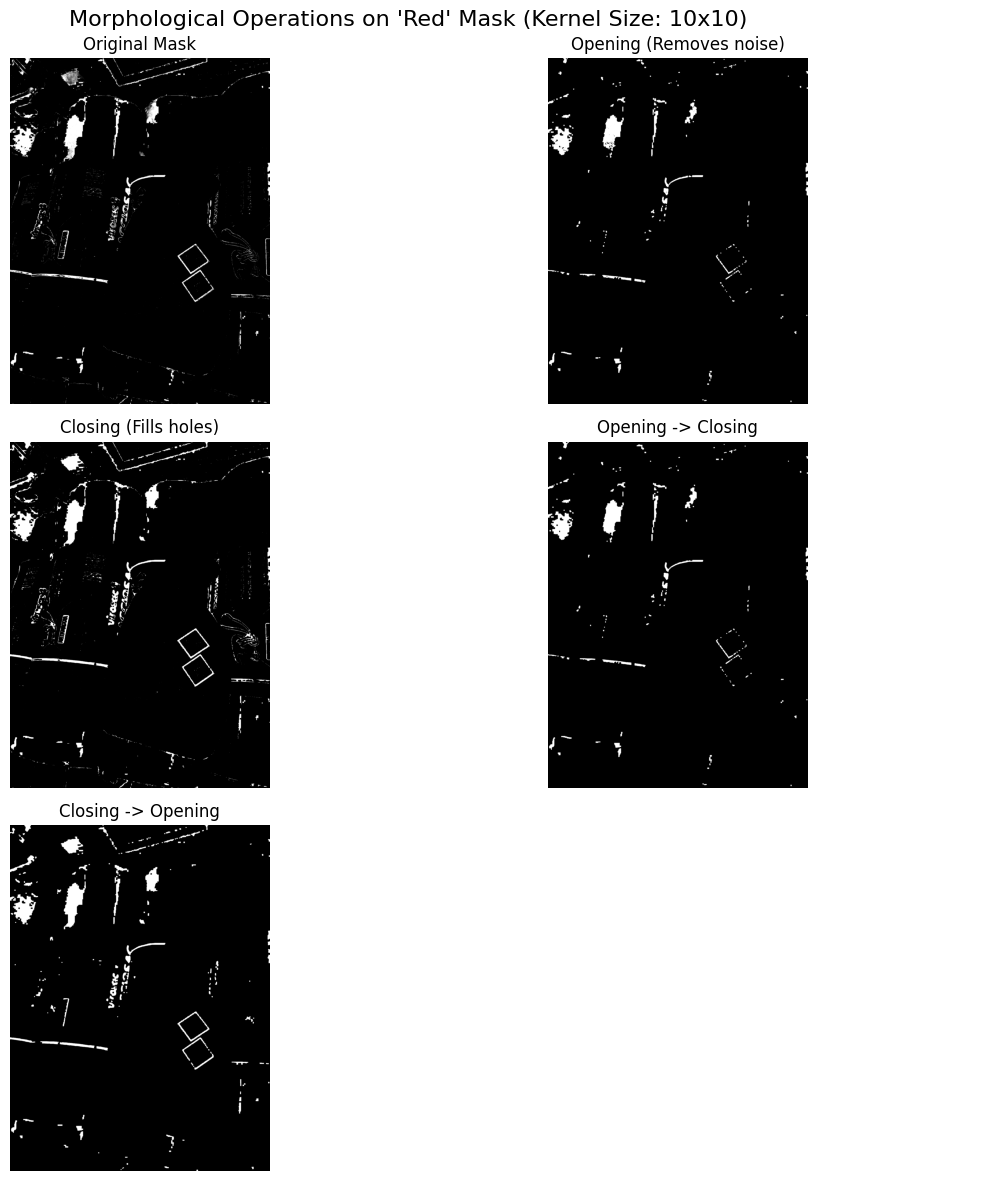

In [23]:
# Applying morphological transformations to smooth masks
print("Applying morphological transformations to smooth masks")

# --- Configuration ---
# Select which mask to process. You can change this index to see effects on other masks.
# 0:Orange, 1:Blue, 2:Yellow, 3:Green, 4:Red, 5:White, 6:Black
mask_index = 4
mask_to_process = all_masks[mask_index]
mask_name = all_color_names[mask_index]

# Define the kernel for morphology.
# A larger kernel size will have a more pronounced effect.
kernel_size = 10
kernel = np.ones((kernel_size, kernel_size), np.uint8)
# For a circular kernel, you could use:
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
# --- End Configuration ---

print(f"Processing '{mask_name}' mask with a {kernel_size}x{kernel_size} kernel...")

# 1. Opening: Erosion followed by Dilation. Useful for removing noise.
opening = cv2.morphologyEx(mask_to_process, cv2.MORPH_OPEN, kernel)

# 2. Closing: Dilation followed by Erosion. Useful for filling small holes.
closing = cv2.morphologyEx(mask_to_process, cv2.MORPH_CLOSE, kernel)

# 3. Opening followed by Closing. 
opened_then_closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# 4. Closing followed by Opening. 
closed_then_opened = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)


# --- Visualization ---
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle(f"Morphological Operations on '{mask_name}' Mask (Kernel Size: {kernel_size}x{kernel_size})", fontsize=16)

# Original Mask
axs[0, 0].imshow(mask_to_process, cmap='gray')
axs[0, 0].set_title("Original Mask")
axs[0, 0].axis('off')

# Opened Mask
axs[0, 1].imshow(opening, cmap='gray')
axs[0, 1].set_title("Opening (Removes noise)")
axs[0, 1].axis('off')

# Closed Mask
axs[1, 0].imshow(closing, cmap='gray')
axs[1, 0].set_title("Closing (Fills holes)")
axs[1, 0].axis('off')

# Opened then Closed Mask
axs[1, 1].imshow(opened_then_closed, cmap='gray')
axs[1, 1].set_title("Opening -> Closing")
axs[1, 1].axis('off')

# Closed then Opened Mask
axs[2, 0].imshow(closed_then_opened, cmap='gray')
axs[2, 0].set_title("Closing -> Opening")
axs[2, 0].axis('off')

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()